# Senior Project: AI vs Human Text

## Data Collection

### Currently using my old writing assignments and some random essays. 

## Data Preprocessing

!pip install python-docx

In [73]:
from docx import Document
import os
import pandas as pd
import re

# Textual metadata calculation functions
def get_word_count(text):
    return len(text.split())

def get_sentence_count(text):
    sentences = re.split(r'[.!?]+', text)
    return len([s for s in sentences if s.strip()])

def get_avg_word_length(text):
    words = text.split()
    if words:
        return sum(len(word) for word in words) / len(words)
    else:
        return 0

def get_paragraph_count(text):
    paragraphs = text.split('\n\n')  # Assuming paragraphs are separated by double newlines
    return len([p for p in paragraphs if p.strip()])

def get_lexical_diversity(text):
    words = text.split()
    unique_words = set(words)
    if words:
        return len(unique_words) / len(words)
    else:
        return 0

# Function to remove "Works Cited" section
def remove_after_works_cited(text):
    lower_text = text.lower()
    reference_headings = ["works cited", "references", "bibliography", "reference list"]
    
    for heading in reference_headings:
        index = lower_text.find(heading)
        if index != -1:
            return text[:index]

    return text

# Function to process Word documents and extract metadata
def docx_to_text_and_metadata(path, label):
    doc = Document(path)
    full_text = '\n\n'.join(paragraph.text for paragraph in doc.paragraphs if paragraph.text)
    cleaned_text = remove_after_works_cited(full_text)
    
    title = doc.core_properties.title
    subject = doc.core_properties.subject
    
    word_count = get_word_count(cleaned_text)
    sentence_count = get_sentence_count(cleaned_text)
    avg_word_length = get_avg_word_length(cleaned_text)
    paragraph_count = get_paragraph_count(cleaned_text)
    lexical_diversity = get_lexical_diversity(cleaned_text)
    
    return {
        'text': cleaned_text,
        'title': title,
        'subject': subject,
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'paragraph_count': paragraph_count,
        'lexical_diversity': lexical_diversity,
        'file_name': os.path.basename(path),
        'label': label
    }

# Function to process a directory of essays
def process_essays_directory(docs_dir, label):
    doc_files = [f for f in os.listdir(docs_dir) if f.endswith('.docx')]
    docs_data = []

    for file_name in doc_files:
        file_path = os.path.join(docs_dir, file_name)
        doc_data = docx_to_text_and_metadata(file_path, label)
        docs_data.append(doc_data)

    return docs_data

# Directories for human-written and AI-generated essays
human_docs_dir = r'C:\Users\Colin\OneDrive\Desktop\Human Essays SP'  # Adjust the path as needed
ai_docs_dir = r'C:\Users\Colin\OneDrive\Desktop\AI Essays SP'  # Adjust the path as needed

# Process each directory with the appropriate label
human_docs_data = process_essays_directory(human_docs_dir, 'Human')
ai_docs_data = process_essays_directory(ai_docs_dir, 'AI')

# Combine the data from both sources
all_docs_data = human_docs_data + ai_docs_data

# Convert to DataFrame and export to CSV
df_all_docs = pd.DataFrame(all_docs_data)
df_all_docs.to_csv('combined_docs_with_metadata.csv', index=False)
print("Document data exported to 'combined_docs_with_metadata.csv'.")

Document data exported to 'combined_docs_with_metadata.csv'.


## Find Directory where .csv File is Stored

In [74]:
import os

current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

Current working directory: C:\Users\Colin


## Attempt Visualization of All Most Frequent Words: NO CLEANING

!pip install matplotlib

!pip install nltk

!pip install wordcloud

In [75]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Colin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Colin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Colin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [76]:
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in string.punctuation]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [82]:
all_words = []
for essay in df_all_docs['text']:  
    all_words.extend(preprocess_text(essay))

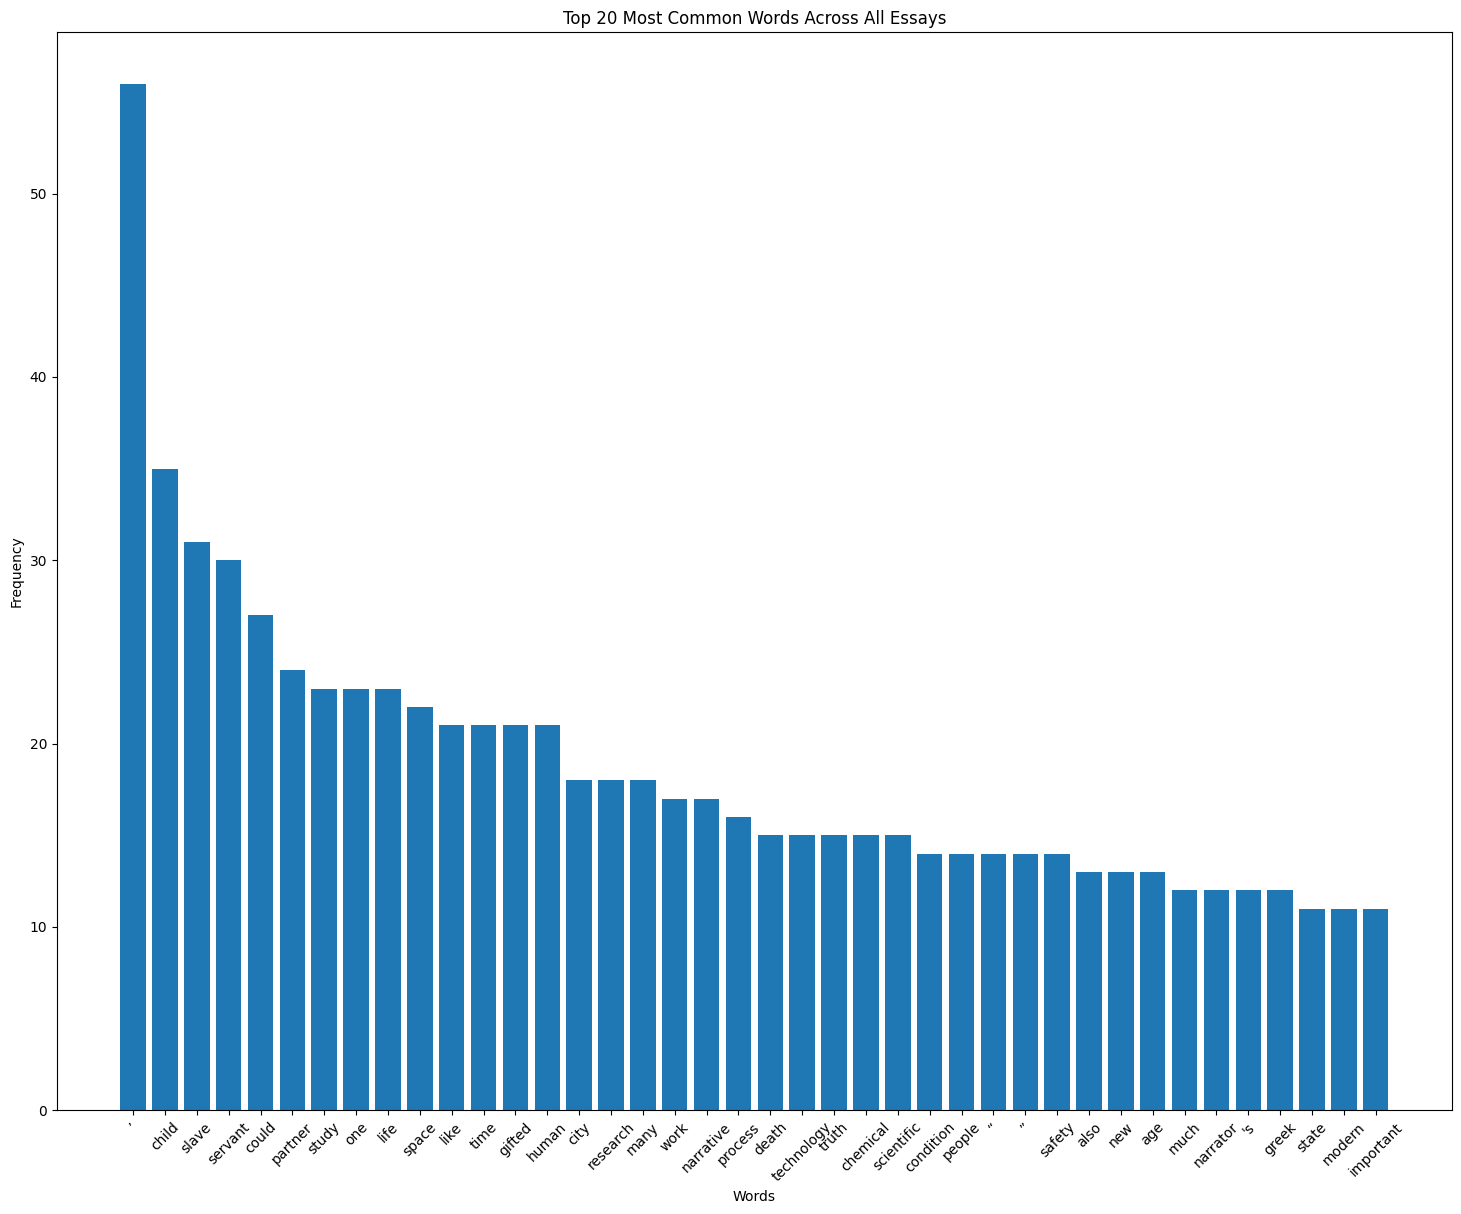

In [78]:
from nltk import FreqDist

# Create a frequency distribution of words
freq_dist = FreqDist(all_words)

# Get the 20 most common words
most_common_words = freq_dist.most_common(40)
words, frequencies = zip(*most_common_words)

# Create a bar chart
plt.figure(figsize=(18, 14))
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Words Across All Essays')
plt.show()

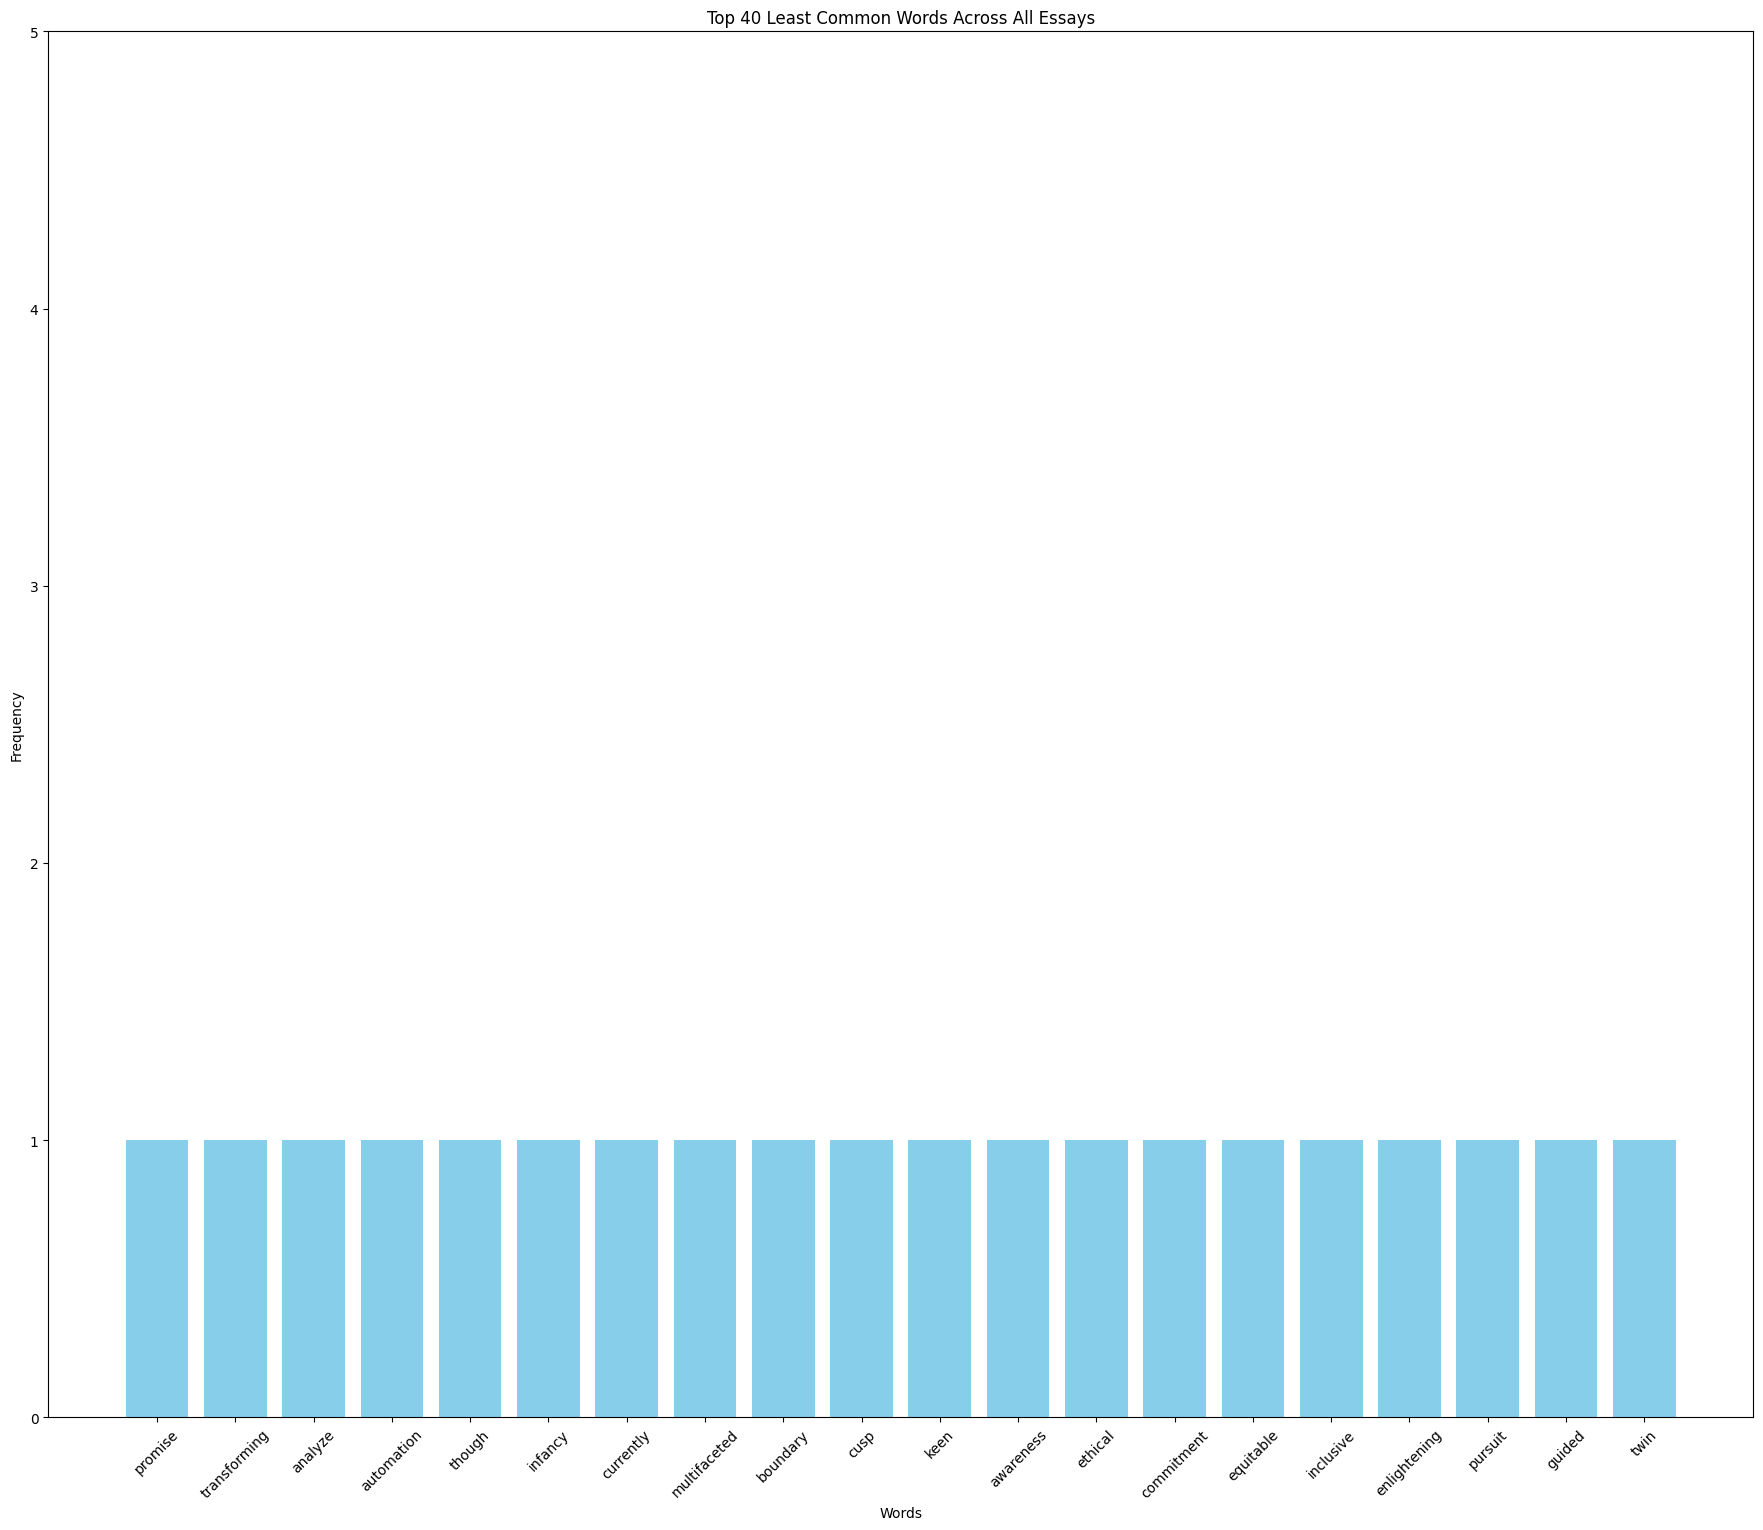

In [88]:
least_common_words = freq_dist.most_common()[-20:]
words, frequencies = zip(*least_common_words)

# Create a bar chart
plt.figure(figsize=(22, 18))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate the word labels for better readability
plt.title('Top 40 Least Common Words Across All Essays')
plt.ylim(min(frequencies) - 1, max(frequencies) + 4)
plt.show()